In [7]:
import os
import cv2
import sys
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from PIL import Image,ImageFilter

In [8]:
original_path0 = "original/0/"
original_path1 = "original/1/"
resize_path0 = "resize/0/"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 数字图像处理


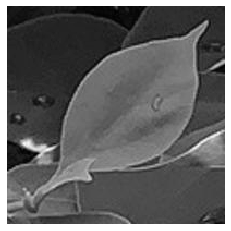

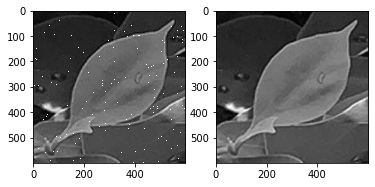

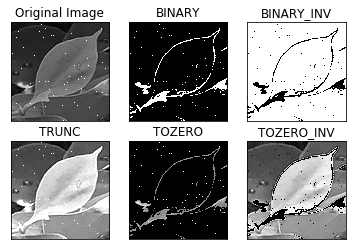

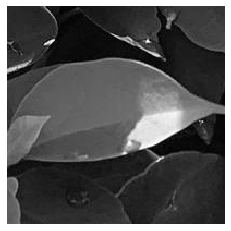

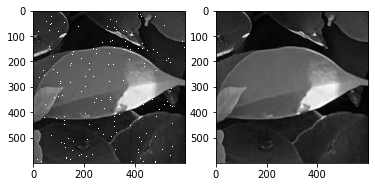

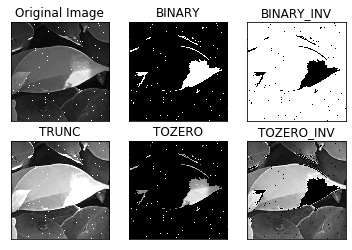

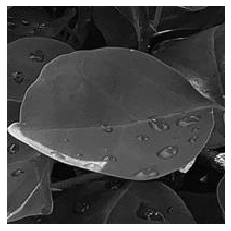

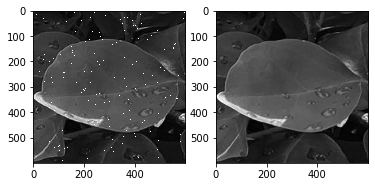

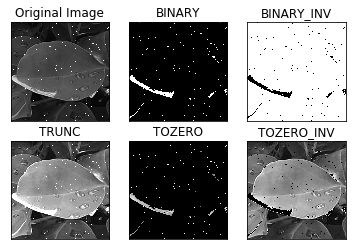

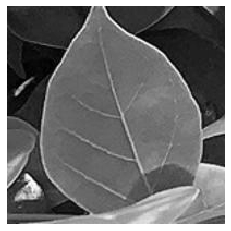

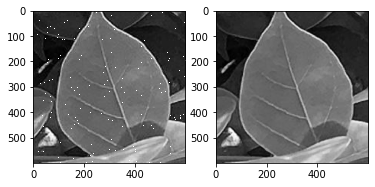

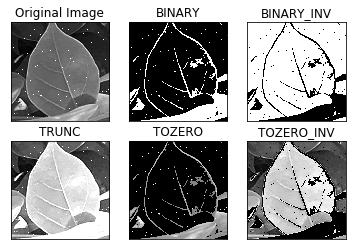

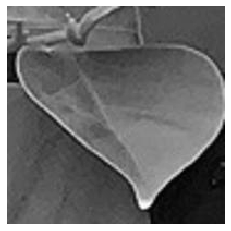

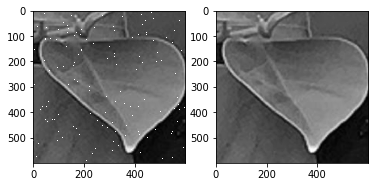

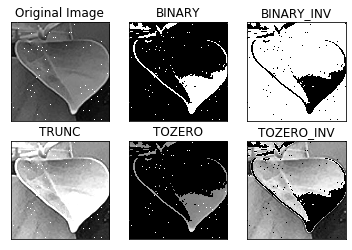

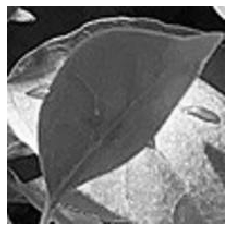

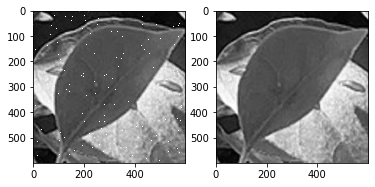

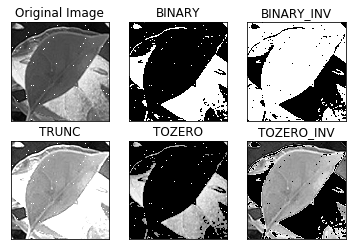

In [9]:
#分别将original下的文件夹中的图片压缩为600*600的图片，并存入resize文件夹下
df = pd.DataFrame(columns=['H[0]','H[1]','H[2]','H[3]','H[4]','H[5]','H[6]','label'])
for filename0 in os.listdir(original_path1):
    if os.path.splitext(filename0)[1] == '.png':
        #1. 读取图片的灰度图
#         image = cv2.imread(original_path0 + filename0,0)
        img = cv2.imread(original_path1 + filename0)
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        newImage = cv2.resize(img_gray, dsize=(600, 600))
#         灰度图
        plt.imshow(img_gray,cmap="gray")
        plt.axis('off')
        plt.show()
        
        #直方图均值化
#         equ = cv2.equalizeHist(newImage)
#         cv2.imshow('p', equ) #要本地跑
#         plt.axis('off')
#         plt.show()
        #2. 图像裁剪
        
        
        #3. 图像平滑
        # 中值滤波模板
        for i in range(2000): #添加点噪声
            temp_x = np.random.randint(0,newImage.shape[0])
            temp_y = np.random.randint(0,newImage.shape[1])
            newImage[temp_x][temp_y] = 255
        blur = cv2.medianBlur(newImage,5)
        plt.subplot(1,2,1),plt.imshow(newImage,'gray')#默认彩色，另一种彩色bgr
        plt.subplot(1,2,2),plt.imshow(blur,'gray')
        plt.show()
#         plt.savefig("med.png")
        
        #4. 图像分割
        ret,thresh1 = cv2.threshold(newImage,127,255,cv2.THRESH_BINARY)
        ret,thresh2 = cv2.threshold(newImage,127,255,cv2.THRESH_BINARY_INV)
        ret,thresh3 = cv2.threshold(newImage,127,255,cv2.THRESH_TRUNC)
        ret,thresh4 = cv2.threshold(newImage,127,255,cv2.THRESH_TOZERO)
        ret,thresh5 = cv2.threshold(newImage,127,255,cv2.THRESH_TOZERO_INV)
        
        titles = ['Original Image','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV']
        images = [newImage, thresh1, thresh2, thresh3, thresh4, thresh5]
        for i in range(6):
            plt.subplot(2,3,i+1),plt.imshow(images[i],'gray')
            plt.title(titles[i])
            plt.xticks([]),plt.yticks([])
        plt.show()



        #5. 边缘检测 拉普拉斯算子
#         dst_img = cv2.Laplacian(img, cv2.CV_32F)
#         laplacian_edge = cv2.convertScaleAbs(dst_img)
#         dst_img_gray = cv2.Laplacian(img_gray, cv2.CV_32F)
#         laplacian_edge_gray = cv2.convertScaleAbs(dst_img_gray)
#         cv2.imshow("img", img)
#         cv2.imshow("laplacian_edge", laplacian_edge)
#         cv2.imshow("img_gray", img_gray)
#         cv2.imshow("laplacian_edge_gray ", laplacian_edge_gray)
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()
        
        #6. 特征提取
        HuMoments = cv2.HuMoments(cv2.moments(newImage)).flatten()
        HuMoments = HuMoments.reshape(-1,7)
        df1 = pd.DataFrame(HuMoments,columns=['H[0]','H[1]','H[2]','H[3]','H[4]','H[5]','H[6]'])
        df1['label'] = 1
#         print(df1)
        df= df.append(df1, ignore_index=True)
#         df = pd.DataFrame(HuMoments,columns=['H[0]','H[1]','H[2]','H[3]','H[4]','H[5]','H[6]'])
#         df['label'] = 1
#         print(df)
#         print(HuMoments)

df.to_csv('./train/1.csv')
        
        

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.FC1 = nn.Linear(7, 32)
        self.FC2 = nn.Linear(32, 2)  
    
    def forward(self, x):
        x = F.relu(self.FC1(x))
        x = self.FC2(x)
        return x

In [11]:
model = Net()

#define LOSS and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01)

model

Net(
  (FC1): Linear(in_features=7, out_features=32, bias=True)
  (FC2): Linear(in_features=32, out_features=2, bias=True)
)

In [12]:
from sklearn.preprocessing import OneHotEncoder
dataset0 = pd.read_csv("./train/0.csv")
dataset1 = pd.read_csv("./train/1.csv")

dataset = dataset0.append(dataset1, ignore_index=True)
print(dataset)
features = dataset.loc[:, 'H[0]':'H[6]']
X = features.values
y = np.array(dataset['label'].values)
y = y.reshape(-1, 1)
# encoder = OneHotEncoder(sparse=False)
# encoder.fit(y)
# y = encoder.transform(y)
# print(y)

    Unnamed: 0      H[0]          H[1]          H[2]          H[3]  \
0            0  0.001199  1.385285e-08  1.351528e-12  8.728310e-13   
1            1  0.001101  6.625422e-09  1.388906e-11  4.995254e-12   
2            2  0.001106  2.238565e-08  4.714627e-11  1.066162e-11   
3            3  0.001406  3.088263e-08  7.878545e-13  1.327582e-12   
4            4  0.001523  3.878321e-09  2.552067e-11  2.198599e-12   
5            5  0.001684  6.958897e-08  8.788412e-11  5.568744e-12   
6            0  0.001843  7.900137e-08  1.002488e-10  2.826449e-11   
7            1  0.002096  8.888848e-08  5.666574e-11  1.562020e-11   
8            2  0.002430  1.682500e-07  2.861450e-11  3.577973e-11   
9            3  0.001593  1.281062e-08  2.322057e-10  2.181958e-11   
10           4  0.001714  5.207760e-09  1.858122e-10  1.498111e-11   
11           5  0.001419  3.440915e-08  2.620161e-11  5.681358e-11   

            H[4]          H[5]          H[6]  label  
0   7.658503e-26 -7.931011e-18  9.4

In [13]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
# dataset = pd.read_csv("./train/0.csv")
# data_dummies = pd.get_dummies(dataset)
# features = data_dummies.loc[:, 'H[0]':'H[6]']
# X = features.values
# y = data_dummies['label'].values
# print(len(y))

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val= train_test_split(X_train, y_train,test_size=0.2, random_state=1)
# print(y_train)

BATCH_SIZE = 10
# num_classes = ['full', 'lack']

# train = dataset.loc[0:1, ['H[0]','H[1]','H[2]','H[3]','H[4]','H[5]','H[6]']]
# y_train = dataset.loc[0:1, ['label']]
# y_train = torch.tensor(data=y_train.values).type(torch.LongTensor) 
# y_train_torch = torch.zeros(BATCH_SIZE, 2).scatter_(1, y_train, 1)
x_train_torch = torch.tensor(data=X_train).type(torch.FloatTensor)
y_train_torch = torch.tensor(data=y_train).type(torch.LongTensor) 
# # print(one_hot,y_train_torch.size())
# # x_train_torch = torch.tensor(data=x_train.values,dtype=torch.float32)
# # y_train_torch = torch.tensor(data=y_train.values,dtype=torch.float32)

torch_dataset = TensorDataset(x_train_torch, y_train_torch)  # 训练的数据集
train_loader = DataLoader(dataset=torch_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [14]:
model.train()
MAX_EPOCH = 10
loss = 0
for epoch in range(MAX_EPOCH):
    for step, (inputs, labels) in enumerate(train_loader):
#         print(step, inputs.size(), labels.size())
        inputs = torch.tensor(inputs)
        y_train_pred = model(inputs)
        labels=torch.tensor(labels, dtype=torch.long)
#         print(y_train_pred.size(),y_train_pred.squeeze().size(),labels.size())
        loss = criterion(y_train_pred, labels.squeeze())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
         ##print loss in each 50 steps
        if step % 500 == 0: # print every 50 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, step+1, loss.data.item()))
print('Finished Training') 

[1,     1] loss: 0.644
[2,     1] loss: 0.643
[3,     1] loss: 0.642
[4,     1] loss: 0.641
[5,     1] loss: 0.641
[6,     1] loss: 0.640
[7,     1] loss: 0.639
[8,     1] loss: 0.638
[9,     1] loss: 0.637
[10,     1] loss: 0.636
Finished Training


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


In [15]:
#Evaluate model
model.eval()
loss = 0.0
correct = 0.0
torch_dataset_test = TensorDataset(x_train_torch, y_train_torch)  # 训练的数据集
test_loader = DataLoader(dataset=torch_dataset_test, batch_size=BATCH_SIZE, shuffle=False)

print(len(test_loader.dataset))
for inputs, labels in test_loader:
    inputs = torch.tensor(inputs)
    y_test_pred = model(inputs)
    labels=torch.tensor(labels, dtype=torch.long)
    ####### calculate the sum of loss
    loss += criterion(y_test_pred, labels.squeeze()).data.item()
#     print(inputs.size(),y_test_pred.size(),labels.squeeze().size())
    
    ####### calulate teh accuracy
    _, predicted = torch.max(y_test_pred.data, 1)
    c = (predicted == labels).squeeze()
#     print('hhh: ',c,sum(c))
    correct += sum(c)

print('Correct Recognition: ', correct)            
acc = 100.*correct/len(test_loader.dataset)
# print('acc: ', acc.numpy()[-1]) 
print('Testset:\nBatch numbers:', len(test_loader), 'Inputs numbers:', len(test_loader.dataset))
print('Average loss:', loss/len(test_loader), 'Accuracy:', acc.numpy()[-1])
# print('Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)'.format(loss/len(test_loader), correct, len(test_loader.dataset), acc))

7
Correct Recognition:  tensor([5., 5., 5., 5., 5., 5., 5.])
Testset:
Batch numbers: 1 Inputs numbers: 7
Average loss: 0.6352347731590271 Accuracy: 71.42857


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
